In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
# update gloabl matplotlib settings
parameters = {'axes.labelsize': 20, 'axes.titlesize': 20, 'figure.titlesize':20,
              'xtick.labelsize':14, 'ytick.labelsize':14, 'legend.fontsize':12, 'legend.title_fontsize':12}
plt.rcParams.update(parameters)

# Gloabl pandas setting
pd.set_option('mode.chained_assignment', None) # disalarm SettingWithCopyWarning


# Predicting Mortality Rate Among Non-traumatic Intracerebral Haemorrhage Patients in Intensive Care Unit (ICU) Using MIMIC-IV Dataset

In this project, we will investigate the mortality rate of patients with non-traumatic intracerebral haemorrhage in the intensive care unit. We intend to compare the accuracy of mortality rate using three different classifiers, namely logistic regression, k-nearest neighbour, and random forest. 

Why is it critical to determine the mortality rate of patients with non-traumatic intracerebral haemorrhage? Stroke is a major health issue that affects people all over the world. Nontraumatic intracerebral haemorrhage (ICH) is a type of stroke in which a hematoma forms within the brain parenchyma, with or without blood extension into the ventricles (Rajashekar & Liang 2022). ICH affects over 2 million people each year and accounts for up to 10%–15% of all strokes (Cordonnier et al., 2018; Vilela & Wiesmann, 2020), with long-term morbidity and a high mortality rate when compared to other types of strokes (Tatlisumak et al., 2018). Carolei et al. (1997) and Van Asch et al. (2010) estimate that approximately 35% of ICH patients die within seven days, and approximately 50% die within 30 days. Furthermore, the global cost of caring for ICH patients, particularly those in intensive care units, is enormous (ICUs). As a result, it becomes critical to predict the mortality rate among ICH patients as early as possible.

ICH scores were previously used to determine mortality (Hemphill et al., 2001). The ICH score is calculated in the first minute of a patient's visit using the Glasgow Coma Scale (GCS), haemorrhage volume (cm3), intraventricular haemorrhage status, haemorrhage site (supra or infratentorial), and patient's age (Rahmani et al., 2018). The ICH score must be assessed by experienced radiologists and neurologists, which is expensive, time-consuming, and difficult for inexperienced users (Nie et al., 2021). APACHE II and SAPS II are reliable predictors of mortality in ICU patients (Lee et al., 2015; Godinjak et al., 2016). These scores use traditional statistical analysis to identify the most relevant covariates from preselected features, resulting in model oversimplification and discretization, reduced covariates, and poor model performance (Nie et al., 2021).

As a result of the limitations of the methods mentioned above, it is necessary to employ machine learning algorithms. The advantage of machine learning methods is that they allow for the automatic discovery of important variables and empirical patterns in data. It starts with the patient's observation and selects many variables to identify the combination that can predict the outcomes reliably. Machine learning can deal with variables with complex interactions using a variety of algorithms that do not make linear assumptions. Another advantage of machine learning is that it can process many predicted values, allowing for a more comprehensive and in-depth exploration of big data.


# About MIMIC dataset

In [3]:
# Load the data 
# admissions = pd.read_csv('../data/core/admissions.csv')
patients = pd.read_csv('../data/core/patients.csv')
diagnose = pd.read_csv('../data/hosp/d_icd_diagnoses.csv')
subj_diagnose = pd.read_csv('../data/hosp/diagnoses_icd.csv')
icu_stays = pd.read_csv('../data/icu/icustays.csv')
item_names = pd.read_csv('../data/icu/d_items.csv').set_index('itemid')
chart_event = pd.read_csv('../data/icu/chart_event_filtered.csv')

MIMIC is a very large dataset, hence we only selected some part of it. We included the tables from four modules: `core`,  `hosp`, and `icu`. We will take a glance at these modules first.

## `core` module 

The core module stores patient tracking data for MIMIC-IV data analysis. The tables in this module list patient demographics, hospitalizations, and ward stays. 

The most important table is the `patients` table where the information that is consistent for the lifetime of a patient is stored. This will be used to identify each patient.

`dod` column (means "date of death") contains the information about mortality inside the hospital which will be used as target in this study.

In [4]:
patients.head(3)

,subject_id,gender,anchor_age,anchor_year,anchor_year_group,dod
0,10000048,F,23,2126,2008 - 2010,NaN
1,10002723,F,0,2128,2017 - 2019,NaN
2,10003939,M,0,2184,2008 - 2010,NaN


**describe**

## `hosp` module

The hospital module contains electronic health record data during hospitalisation. Since we foucsed on ICU patients in this analysis, most of the tables in this module is not of our interest. The only information we need is the billed diagnosis of patients in order to select our cohort.

`diagnoses_icd.csv` contains the icd code for each subject and the corresponding icd version. With the code and version we can acquire the name of the diagnoses from the `d_icd_diagnoses.csv` file. 

In [5]:
subj_diagnose.head(3)

,subject_id,hadm_id,seq_num,icd_code,icd_version
0,15734973,20475282,3,2825,9
1,15734973,20475282,2,V0251,9
2,15734973,20475282,5,V270,9


In [6]:
diagnose.head(3)

,icd_code,icd_version,long_title
0,0010,9,Cholera due to vibrio cholerae
1,0011,9,Cholera due to vibrio cholerae el tor
2,0019,9,"Cholera, unspecified"


## `icu` module

`icu` module contains the main data we are going to analyze. 

The `icu` data includes intravenous and fluid inputs, patient outputs, procedures, date/time information, and other charted information (chartevents). All events tables have a stay id column to identify ICU patients in icustays and an itemid column to identify concepts in d items.

`icustays.csv` tracks information for ICU stays including adminission and discharge times. This table will be used to identify the patients who were admitted to the icu since not all patients admitted to ICU. 

In [7]:
icu_stays.head(3)

,subject_id,hadm_id,stay_id,first_careunit,last_careunit,intime,outtime,los
0,17867402,24528534,31793211,Trauma SICU (TSICU),Trauma SICU (TSICU),2154-03-03 04:11:00,2154-03-04 18:16:56,1.587454
1,14435996,28960964,31983544,Trauma SICU (TSICU),Trauma SICU (TSICU),2150-06-19 17:57:00,2150-06-22 18:33:54,3.025625
2,17609946,27385897,33183475,Trauma SICU (TSICU),Trauma SICU (TSICU),2138-02-05 18:54:00,2138-02-15 12:42:05,9.741725


`chart_event_filtered.csv` contains the majority of the data. During their ICU stay, the primary repository of a patient’s information is their electronic chart. The electronic chart displays patients’ routine vital signs and any additional information relevant to their care: ventilator settings, laboratory values, code status, mental status, and so on. Each event is represented by an `item_id` in this table and the real name of the event can be found in the `d_items.csv` file

`chart_event` table is fairly large, so we uploaded a filtered version. The code used for filtering were shown in appendix. 

In [8]:
chart_event.head(3)

,subject_id,hadm_id,stay_id,charttime,storetime,itemid,value,valuenum,valueuom,warning,Unnamed: 10
0,10006277,25610553,30888848,2176-06-08 01:18:00,2176-06-08 01:20:00,224876,Cloudy,0.0,NaN,NaN,NaN
1,10006277,25610553,30888848,2176-06-08 00:57:00,2176-06-08 01:00:00,223770,90,90.0,%,0.0,NaN
2,10006277,25610553,30888848,2176-06-08 04:18:00,2176-06-08 04:18:00,223988,Clear,0.0,NaN,NaN,NaN


In [9]:
item_names.head(3)

,label,abbreviation,linksto,category,unitname,param_type,lownormalvalue,highnormalvalue
itemid,,,,,,,,
220003,ICU Admission date,ICU Admission date,datetimeevents,ADT,NaN,Date and time,NaN,NaN
220045,Heart Rate,HR,chartevents,Routine Vital Signs,bpm,Numeric,NaN,NaN
220046,Heart rate Alarm - High,HR Alarm - High,chartevents,Alarms,bpm,Numeric,NaN,NaN


# The Cohort 
Here we select the patients dignosed with ICH from the whole hospital addmission. The corresponding ICD codes are 'I61*' (ICD-10) and '431*' (ICD-9). 

In [10]:
diagnose[diagnose['icd_code'].str.contains('I61')].head(3)

,icd_code,icd_version,long_title
24846,I61,10,Nontraumatic intracerebral hemorrhage
24847,I610,10,Nontraumatic intracerebral hemorrhage in hemis...
24848,I611,10,Nontraumatic intracerebral hemorrhage in hemis...


In [11]:
diagnose[diagnose['icd_code'].str.contains('^431')].head(3)

,icd_code,icd_version,long_title
4850,431,9,Intracerebral hemorrhage


Then we filter the patients who were addmitteed to the intensive care unit. 

In [12]:
icu_ids = icu_stays['subject_id'].unique()

In [13]:
def get_icu_cohort(icd10, icd9):
    """
    Input parameters are the icd code for a certain disease. For higher reliability, they should be regular expression. 
    """
    # filter all diagnosed subjects
    df1=patients.set_index('subject_id') 
    df_icd10=subj_diagnose[subj_diagnose['icd_code'].str.contains(str(icd10))]
    df_icd9 = subj_diagnose[subj_diagnose['icd_code'].str.contains(str(icd9))]
    df_icdall=pd.concat([df_icd9,df_icd10]).drop_duplicates('subject_id', keep='first')
    # filter the patients admitted to icu
    df_icu = df_icdall[df_icdall['subject_id'].isin(icu_ids)].set_index('subject_id')
    data = df_icu.join(df1,how='left')
    # add the target, i.e., mortality flag to the table
    data['dod']=data['dod'].replace(np.nan, 0, regex=True)
    data['dod']=data['dod'].replace('-', 1, regex=True)

    return data

def mortality_rate(df):
    """Calculate the mortality rate for selected cohort. """
    return np.count_nonzero(df['dod']==1)/len(df['dod'])

In [14]:
cohort = get_icu_cohort('I61',r'^431')
print('cohort size', cohort.shape[0])
print('mortality rate', mortality_rate(cohort))
cohort

cohort size 2485
mortality rate 0.2784708249496982


,hadm_id,seq_num,icd_code,icd_version,gender,anchor_age,anchor_year,anchor_year_group,dod
subject_id,,,,,,,,,
12116269,24214849,2,431,9,M,66,2166,2008 - 2010,0
12155595,26672436,2,431,9,F,52,2168,2008 - 2010,0
19620109,26497452,2,431,9,F,66,2128,2008 - 2010,0
19330004,20802265,1,431,9,M,52,2187,2008 - 2010,0
18414729,22609366,2,431,9,F,60,2152,2008 - 2010,0
...,...,...,...,...,...,...,...,...,...
14050724,20952526,1,I615,10,F,57,2112,2011 - 2013,0
12557389,21294125,1,I613,10,F,79,2151,2017 - 2019,0
18065731,25556934,1,I618,10,M,46,2137,2011 - 2013,0


The mortality rete of this cohort is 0.2784. This proportion means this dataset is "Slight Imbalance" which means an imbalanced classification problem where the distribution of examples is uneven by a small amount in the training dataset. However slight imbalance typically don't affect most models, the problem can often be treated like a normal classification predictive modeling problem.  (https://machinelearningmastery.com/what-is-imbalanced-classification/)

## Demographic Information of the Cohort 

Although the distribution of gender and age in machine learning is not as important as in medical statisctics, it is always good to know the characteristic of the population as this knowledge can help us determine whether our conclusion is generalizable. We will plot the gender and age distribution:

In [15]:
def fig_set():
    """make figures nice looking"""
    ax = plt.gca()
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    plt.tight_layout()
    

<AxesSubplot:xlabel='gender', ylabel='count'>

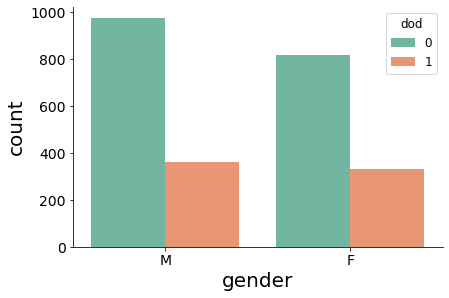

In [16]:
plt.figure();fig_set()
sns.countplot(x='gender', data=cohort,hue='dod',palette='Set2')

<AxesSubplot:xlabel='anchor_age', ylabel='Count'>

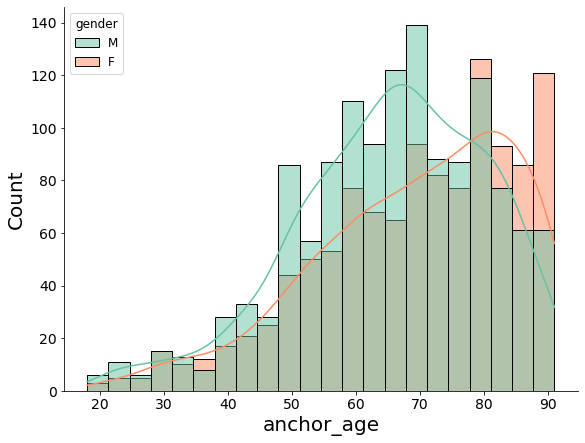

In [17]:
plt.figure(figsize=(8,6));fig_set()
sns.histplot(x='anchor_age',hue='gender',data=cohort,kde=True,palette='Set2')


In this figure we can find that there is not clear gender bias in this cohort. Though the age of each group is slightly different, they all concertrated on aged people. Our result will be more trustworthy in aged people (above 50 years)

# Feature Engineering

## Cohort Features

First, we need to drop unneccesary columns. `icd_code` and `icd_version` is not not needed after selecting the cohort. Since we mainly foucused on icu data `hadm_id`,`seq_num` is not useful. `anchor year` is the encrypted admission year of the patient, it's not related to our question, so won't included them. 


In [18]:
cohort_final = cohort[['gender', 'anchor_age','dod']]
cohort_final

,gender,anchor_age,dod
subject_id,,,
12116269,M,66,0
12155595,F,52,0
19620109,F,66,0
19330004,M,52,0
18414729,F,60,0
...,...,...,...
14050724,F,57,0
12557389,F,79,0
18065731,M,46,0


In [19]:
# Covert gender to 0 and 1
cohort_final['gender'].replace('F', 0, regex=True,inplace=True)
cohort_final['gender'].replace('M', 1, regex=True,inplace=True)

# Convert the datatype of the target, i.e., the dod
cohort_final['dod'] = cohort_final['dod'].astype(np.int64)

In [20]:
print(cohort_final.dtypes)
cohort_final.head()

gender        object
anchor_age     int64
dod            int64
dtype: object


,gender,anchor_age,dod
subject_id,,,
12116269,1,66,0
12155595,0,52,0
19620109,0,66,0
19330004,1,52,0
18414729,0,60,0


In [21]:
# cohort subject id is used to select data from other tables.
cohort_ind = cohort.index
cohort_ind

Int64Index([12116269, 12155595, 19620109, 19330004, 18414729, 14731854,
            19513478, 14444370, 17759541, 11906321,
            ...
            12424554, 16078400, 17962961, 10445331, 16633337, 14050724,
            12557389, 18065731, 12853711, 17293846],
           dtype='int64', name='subject_id', length=2485)

## Chartted Event

In [22]:
chart_pivot= chart_event.pivot(index='subject_id', columns='itemid', values='value')
chart_pivot.head()

itemid,220045,220046,220047,220048,220179,220180,220181,220210,220228,220277,...,227443,227457,227465,227466,227467,227944,227968,227969,228096,228299
subject_id,,,,,,,,,,,,,,,,,,,,,
10006277,95,120,60,AF (Atrial Fibrillation),139,82,94,37,13,95,...,25,178,18.5,28.1,2,3 rails up,Yes,Bed locked in low position,NaN,NaN
10007677,84,130,50,SR (Sinus Rhythm),88,51,58,18,9.8,95,...,26,193,13.8,27.4,1.3,3 rails up,Yes,Pain evaluated and treated,0 Alert and calm,0 Alert and calm
10013310,100,130,50,ST (Sinus Tachycardia),116,61,84,19,8.8,100,...,27,290,12.8,27.6,1.3,3 rails up,Yes,Lines and tubes concealed,0 Alert and calm,0 Alert and calm
10017492,88,120,60,1st AV (First degree AV Block),149,63,71,25,8.4,98,...,23,357,11.1,23.7,1,3 rails up,Yes,Adequate lighting,0 Alert and calm,0 Alert and calm
10025463,81,120,60,ST (Sinus Tachycardia),122,81,91,22,NaN,97,...,NaN,NaN,NaN,NaN,NaN,3 rails up,Yes,Pain evaluated and treated,"-5 Unarousable, no response to voice or physic...","-2 Light sedation, briefly awakens to voice (e..."


In [23]:
def return_cat_index(cat):
    """
    Create an Index object for each kind of item. 
    """
    return fmeanings[fmeanings['param_type']==cat].index.to_list()

fmeanings = pd.read_csv('./etc/feature_meanings.csv').set_index('itemid')

num_index = return_cat_index('Numeric')
nom_index = return_cat_index('Nominal')
ord_index = return_cat_index('Ordinal')
bin_index = return_cat_index('Binary')

In [24]:
def fill_nan_class(index):
    """
    Fill the categorical variables in chart_pivot with 'itemid + untested'
    This function set the new values to the original dataframe.
    """
    for item in index:
        chart_pivot.loc[:,item] = chart_pivot[item].fillna((str(item)+'untested'))

In [25]:
def fill_nan_mean(df, rd=2):
    for col in list(df.columns[df.isnull().sum() > 0]):
        mean_val = df[col].mean()
        try:
            df[col]=df[col].fillna(mean_val)
        except TypeError:
            continue

In [26]:
# Fill the missing values in categorical variables
fill_nan_class(ord_index)
fill_nan_class(nom_index)
fill_nan_class(bin_index)
# Change the datatype for numeric variables and fill the missing values with overall mean.
chart_pivot[num_index] = chart_pivot[num_index].astype(np.float64)
fill_nan_mean(chart_pivot)

In [27]:
# check if everything is ok
chart_pivot[nom_index]

itemid,220048,223782,223783,223792,223795,223976,223979,223982,223983,223986,...,224650,224876,224879,226168,226732,227121,227240,227288,227343,227969
subject_id,,,,,,,,,,,,,,,,,,,,,
10006277,AF (Atrial Fibrillation),Constant,Back,Repositioned,Patient Verbalized,Normal,Normal,Normal,Normal,Clear,...,None,Cloudy,Patent,Swab,Nasal cannula,Brisk,Systolic,Brisk,Bed rest,Bed locked in low position
10007677,SR (Sinus Rhythm),Aching,Headache,IV Drip,223795untested,Normal,Normal,Normal,Normal,Clear,...,None,Clear,Patent,Swab,Nasal cannula,Brisk,Systolic,Brisk,Nurse assist,Pain evaluated and treated
10013310,ST (Sinus Tachycardia),None,Not Indicated,Repositioned,Non-verbal Cues,Normal,Normal,Normal,Normal,Diminished,...,None,Clear,Patent,Swab,None,Sluggish,Systolic,Brisk,Nurse assist,Lines and tubes concealed
10017492,1st AV (First degree AV Block),Intermittent,Right Hip,Repositioned,Non-verbal Cues,Normal,Normal,Normal,Normal,Clear,...,None,Clear,Patent,Swab,Non-rebreather,Brisk,Systolic,Brisk,Bed rest,Adequate lighting
10025463,ST (Sinus Tachycardia),223782untested,223783untested,223792untested,Change in Vitals,Normal,Normal,Normal,Normal,Clear,...,PVC's,Clear,Patent,Swab,Endotracheal tube,Non-reactive,Systolic,Sluggish,Bed rest,Pain evaluated and treated
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19992425,SB (Sinus Bradycardia),None,Not Indicated,Not applicable,Patient Verbalized,Normal,Normal,Normal,Normal,Clear,...,PAC's,Clear,Patent,Toothbrush (No observed alteration),Nasal cannula,Brisk,Systolic,Brisk,Nurse assist,Call light within reach
19992885,ST (Sinus Tachycardia),None,Not Indicated,IV Drip,Change in Vitals,Normal,Normal,Normal,Normal,Clear,...,None,Clear,Patent,Toothbrush (No observed alteration),Endotracheal tube,Sluggish,Systolic,Sluggish,Nurse assist,Bed locked in low position
19994233,AF (Atrial Fibrillation),None,Not Indicated,Backrub,Patient Verbalized,Normal,Normal,Normal,Normal,Clear,...,None,Clear,Patent,Oral Care Kit (Mild alteration),None,Brisk,Systolic,Brisk,Bed rest,Pain evaluated and treated


In [28]:
from sklearn.preprocessing import OrdinalEncoder
# OrdinalEncoder in sklearn offers a robust, automatic way to convert any ordinal variablels into ordinal integers
# Although we can convert ordinal variables by hand, we have to many features to learn and convert.
# It can learn the strings within each feature and determine which one comes first, so we decided to use this instead of writing our own.  

ord_enc = OrdinalEncoder()
ord_enc.fit(chart_pivot[ord_index + bin_index])
chart_pivot[ord_index + bin_index] = ord_enc.transform(chart_pivot[ord_index + bin_index])


Before doing further analysis, we need to convert the remaining itemid into their names. This will make the one-hot encoding process easier to understand.

In [29]:
# Map from item id to their abbrvation
item_dict = dict()
for item_id in chart_pivot.columns:
    item_dict[item_id] = item_names.loc[item_id, 'abbreviation']

In [30]:
from operator import itemgetter
# operator is a python built-in library

one_hot_encoded = pd.get_dummies(chart_pivot[nom_index],prefix=itemgetter(*nom_index)(item_dict))
one_hot_encoded.head()

,Heart Rhythm_1st AV (First degree AV Block),Heart Rhythm_220048untested,Heart Rhythm_2nd AV M2 (Second degree AV Block - Mobitz 2),Heart Rhythm_A Flut (Atrial Flutter),Heart Rhythm_A Paced,Heart Rhythm_AF (Atrial Fibrillation),Heart Rhythm_AV Paced,Heart Rhythm_Asystole,Heart Rhythm_JR (Junctional Rhythm),Heart Rhythm_LBBB (Left Bundle Branch Block),...,Safety Measures_Medication offered,Safety Measures_Medication reviewed,Safety Measures_Mobility aides within reach,Safety Measures_Non-slip footwear provided,Safety Measures_Not applicable,Safety Measures_Oriented by RN,Safety Measures_Pain evaluated and treated,Safety Measures_Provided comfort with lines and tubes,Safety Measures_Provided distraction,"Safety Measures_Quiet, calm space"
subject_id,,,,,,,,,,,,,,,,,,,,,
10006277,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10007677,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
10013310,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10017492,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10025463,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [31]:
# combine the onehot encoded dataframe with the main dataframe
chart_final = chart_pivot.join(one_hot_encoded).drop(nom_index,axis=1)

In [32]:
chart_final.rename(columns=item_dict,inplace=True)
chart_final.head()

,HR,HR Alarm - High,HR Alarm - Low,NBPs,NBPd,NBPm,RR,Hemoglobin,SpO2,Hematocrit (serum),...,Safety Measures_Medication offered,Safety Measures_Medication reviewed,Safety Measures_Mobility aides within reach,Safety Measures_Non-slip footwear provided,Safety Measures_Not applicable,Safety Measures_Oriented by RN,Safety Measures_Pain evaluated and treated,Safety Measures_Provided comfort with lines and tubes,Safety Measures_Provided distraction,"Safety Measures_Quiet, calm space"
subject_id,,,,,,,,,,,,,,,,,,,,,
10006277,95.0,120.0,60.0,139.0,82.0,94.0,37.0,13.000000,95.0,40.500000,...,0,0,0,0,0,0,0,0,0,0
10007677,84.0,130.0,50.0,88.0,51.0,58.0,18.0,9.800000,95.0,28.700000,...,0,0,0,0,0,0,1,0,0,0
10013310,100.0,130.0,50.0,116.0,61.0,84.0,19.0,8.800000,100.0,28.700000,...,0,0,0,0,0,0,0,0,0,0
10017492,88.0,120.0,60.0,149.0,63.0,71.0,25.0,8.400000,98.0,29.200000,...,0,0,0,0,0,0,0,0,0,0
10025463,81.0,120.0,60.0,122.0,81.0,91.0,22.0,11.386364,97.0,34.335927,...,0,0,0,0,0,0,1,0,0,0


## Combine three tables

In [33]:
combined_df = cohort_final.join([chart_final])

In [34]:
fill_nan_mean(combined_df)
combined_df.head()

,gender,anchor_age,dod,HR,HR Alarm - High,HR Alarm - Low,NBPs,NBPd,NBPm,RR,...,Safety Measures_Medication offered,Safety Measures_Medication reviewed,Safety Measures_Mobility aides within reach,Safety Measures_Non-slip footwear provided,Safety Measures_Not applicable,Safety Measures_Oriented by RN,Safety Measures_Pain evaluated and treated,Safety Measures_Provided comfort with lines and tubes,Safety Measures_Provided distraction,"Safety Measures_Quiet, calm space"
subject_id,,,,,,,,,,,,,,,,,,,,,
12116269,1,66,0,62.0,120.0,50.0,138.0,63.0,83.0,16.0,...,0,0,0,0,0,0,0,0,0,0
12155595,0,52,0,55.0,120.0,50.0,163.0,70.0,81.0,19.0,...,0,0,0,0,0,0,0,0,0,0
19620109,0,66,0,65.0,120.0,55.0,136.0,65.0,94.0,14.0,...,0,0,0,0,0,0,0,0,0,0
19330004,1,52,0,81.0,120.0,50.0,78.0,81.0,65.0,17.0,...,0,0,0,0,0,0,0,0,0,0
18414729,0,60,0,83.0,120.0,50.0,141.0,44.0,78.0,15.0,...,0,0,0,0,0,0,0,0,0,0


## Feature Selection

### Remove feature with co-linearity

There may be some highly correlated features in the model but these features do not provide much information and do not improve the prediction accuracy. These highly correlated features are called multicollinearity, which refers to the distortion of model estimates or difficulty in estimating accurately due to exact correlation or high correlation between explanatory variables in a linear regression model. The model parameter estimates are not interpretable. At the same time, data sets having more features means that they are more likely to receive noise and more likely to receive feature bias. Therefore, when covariance features are found, they should be removed.

In [35]:
num_feature_dic=dict((key, value) for key, value in item_dict.items() if key in num_index)
Numeric_corr_name=list(num_feature_dic.values())


<AxesSubplot:>

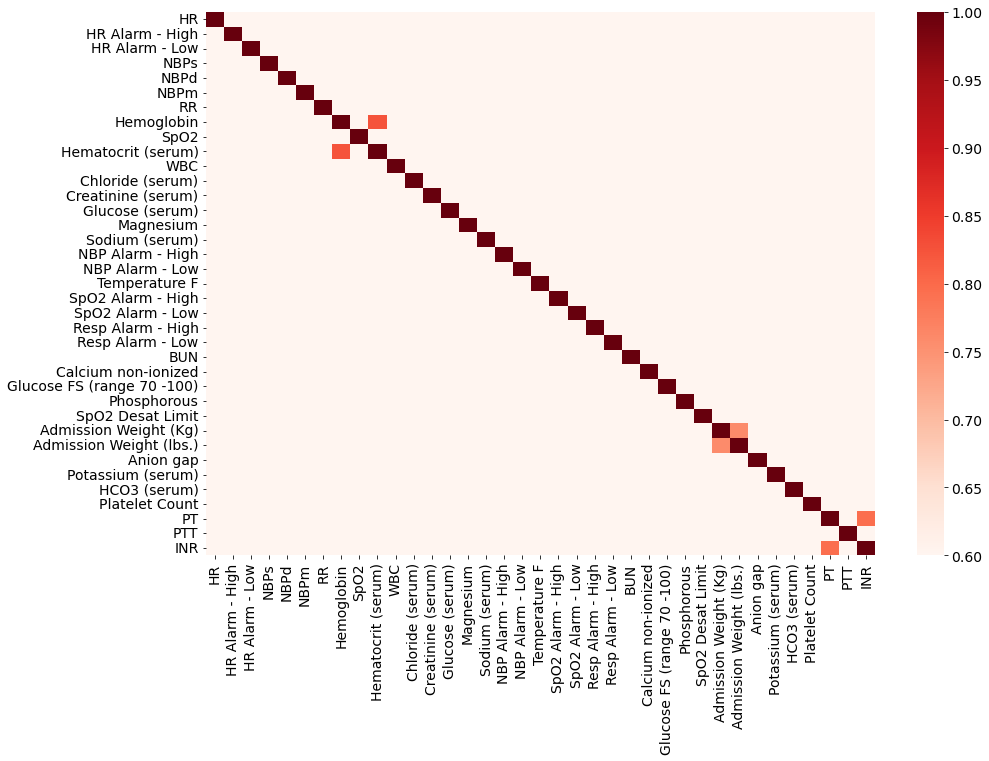

In [36]:
plt.figure(figsize=(15,10))
sns.heatmap(combined_df[Numeric_corr_name].corr(),cmap="Reds",vmin=0.6)

In [37]:
# Here we drop a few feature with relatively high co-linearity with other variables 
combined_df.drop(['Hemoglobin','Admission Weight (Kg)','INR'],axis=1,inplace=True)

### Remove Features with Low Variance
The variance is a value used to describe the variance of the data, but if the variance of the data in the data is too low, the feature has some uniformity and low contribution to the model prediction.These features can be removed

In [38]:
from sklearn.feature_selection import VarianceThreshold
def variance_threshold_selector(data, threshold=0.16):
    selector = VarianceThreshold(threshold)
    selector.fit(data)
    return data[data.columns[selector.get_support(indices=True)]]
new_features=variance_threshold_selector(combined_df)

### Selection Based on Domain Knowledge 

In [39]:
new_features.columns

Index(['gender', 'anchor_age', 'dod', 'HR', 'HR Alarm - High',
       'HR Alarm - Low', 'NBPs', 'NBPd', 'NBPm', 'RR',
       ...
       'Position_Supine', 'Pain Level Response_None',
       'Pain Level Response_Unable to Score', 'Oral Care_Swab',
       'O2 Delivery Device(s)_Endotracheal tube',
       'O2 Delivery Device(s)_Nasal cannula', 'O2 Delivery Device(s)_None',
       'Pupil Response R_Brisk ', 'Pupil Response L_Brisk ',
       'Ambulatory aid_Bed rest'],
      dtype='object', length=123)

We manully checked the features in `new_features` and selected them based on domain knowledge. 

A few features have data leakage problem, such as 'O2 Delivery' related features which are related to how many oxygens are delivered to patients. These are the result of patient's illness but not the cause, so we dropped them.

Some features are directly related to the death or used to confirm wheter a patient is dead or not, such as 'Eye Opening', 'Motor Response' from Glascow Comma Scale. We dropped those features as well. 


In [40]:
final = new_features.drop(['Richmond-RAS Scale', 'Eye Opening', 'O2 Delivery Device(s)_Endotracheal tube', 
                   'Motor Response', 'Pupil Response L_Brisk ','Pupil Response R_Brisk ', 'Verbal Response','O2 Delivery Device(s)_None', 'O2 Delivery Device(s)_Nasal cannula'], axis=1)

# Modelling

In this section, we plan to use several machine learning techniques such as KNN, random forest, logistic regression to predict patients mortality. 

First, we will compare the accuracy of our own KNN code with the KNN model from sklearn to check which one is better. 

Considered KNN is not a interpretable model which makes it not perfect for our research question, we then use logistic regression and random forest. These two model are interpretable thus we can figure out which feature is more important, i.e., the model thinks is more related to patients' death. 

## Train Test Split

In [41]:
# set random seed for reproduceble result
np.random.seed(42)

In [42]:
# Make a copy of the processed dataframe for the modeling
model_df=final.copy()

In [43]:
# pop out the target
y = model_df.pop('dod').values

In [44]:
# convert the dataframe ioto numpy array for the train_test_split function
X = model_df.values

In [45]:
def train_test_split(X, y,train_size):
    """
    Split the data into train set and test set.
    train_size should be a value between 0 and 1 indicating the proportion of the train set
    """
    arr_rand = np.random.rand(X.shape[0])
    split = arr_rand < train_size
    X_train = X[split].astype(np.float64)
    y_train = y[split].astype(np.float64)
    X_test =  X[~split].astype(np.float64)
    y_test =  y[~split].astype(np.float64)
    return X_train, X_test,y_train, y_test

In [46]:
# Perfrom train test split
X_train, X_test, y_train, y_test= train_test_split(X, y,0.8)

# For model interpretaion, need to convert them back to dataframe
X_train = pd.DataFrame(X_train, columns=model_df.columns)
X_test = pd.DataFrame(X_test, columns=model_df.columns)

In [47]:
# For linear model, we need to perform data standardization
X_train_std=(X_train-X_train.mean())/X_train.std()
X_test_std=(X_test-X_test.mean())/X_test.std()
# Round the x_train and x_test to make sure the calculation doesn't take too much resources
X_train_std=np.around(X_train_std.astype(np.float64),2)
X_test_std = np.around(X_test_std.astype(np.float64),2)

## KNN

In this section, we are going to use the K-nearst neighbor to predict the mortality. We will also compare the mdoel written by our self and warpped function provided by sklearn. 

We trained the KNN using different K values ranged from 2 to 20 and then select the model with the best performance.

In [48]:
K_max=20

### My KNN


In [49]:
def My_knncomper_difftest(kmax, X_train_std,X_test_std, y_train,y_test):
    rightnumber = 0           
    Train_acc=[]
    Test_acc=[]  
    print(" maximum K value is "+str(kmax))           
    # Loop through different K numbers
    for k in range(1,kmax):
        rightnumber=0; Train_predict_score=0
        # calculate train accuracy
        predictlist = MYknn(X_train_std, X_train_std, y_train, k)
        for m in range(len(X_train_std)):
            if predictlist[m] == y_train[m]:
                rightnumber = rightnumber + 1
        Train_predict_score = (rightnumber / len(X_train_std))
        Train_acc.append( Train_predict_score * 100)      
        # calculate test accuracy
        rightnumber=0; test_predict_score=0
        predictlist =MYknn(X_test_std, X_train_std, y_train, k)
        for m in range(len(X_test_std)):
            if predictlist[m] == y_test[m]:
                rightnumber = rightnumber + 1
        test_predict_score = (rightnumber / len(y_test))
        Test_acc.append(  test_predict_score * 100)
    return Train_acc, Test_acc
        
def MYknn(test_object, training_object, training_object_target, K):
    predictlist = []
    # Loop through every elements
    for newpoint in test_object:
        dataSetSize = training_object.shape[0]
        # caculate the distance matrix between new point and all training  points 
        diffMat= np.tile(newpoint, (dataSetSize, 1)) - training_object
        sqDistances = (diffMat**2).sum(axis=1)
        distances = sqDistances ** 0.5
        # argsort: sort array and return array index,keep the orignal array.
        sortedDistIndicies = distances.argsort()
        classCount = {}
        for i in range(K):
            # get lables form 0 to k nearest training points
            voteIlabel = training_object_target[sortedDistIndicies[i]]
            #Count different lables number 
            classCount[voteIlabel] = classCount.get(voteIlabel, 0) + 1  
            # sort lable and get the most lable
            sortedClassCount = sorted(classCount.items(), key=itemgetter(1), reverse=True)
        # store predict newpoint label 
        predictlist.append(sortedClassCount[0][0])
    return predictlist


In [50]:
# This might take a few minute to run
myknn_train_scores, myknn_test_scores = My_knncomper_difftest(K_max,X_train_std.values,X_test_std.values, y_train,y_test)

 maximum K value is 20


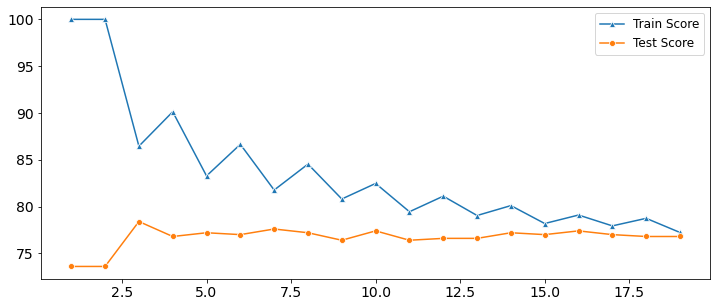

In [51]:
plt.figure(figsize=(12,5))
p = sns.lineplot(x=range(1,20),y=myknn_train_scores,marker='^',label='Train Score')
p = sns.lineplot(x=range(1,20),y=myknn_test_scores,marker='o',label='Test Score')

### Sklearn KNN

In [52]:
from sklearn.neighbors import KNeighborsClassifier

np.random.seed(40)
test_scores = []
train_scores = []

for i in range(1,K_max):

    knn = KNeighborsClassifier(i)
    knn.fit(X_train_std,y_train)
    
    train_scores.append(knn.score(X_train_std,y_train))
    test_scores.append(knn.score(X_test_std,y_test))


In [53]:
## score that comes from testing on the datapoints that were split in the beginning to be used for testing solely
max_test_score = max(test_scores)
test_scores_ind = [i for i, v in enumerate(test_scores) if v == max_test_score]
print(f'Max test score {max_test_score} and k = {test_scores_ind}')

Max test score 0.784 and k = [2]


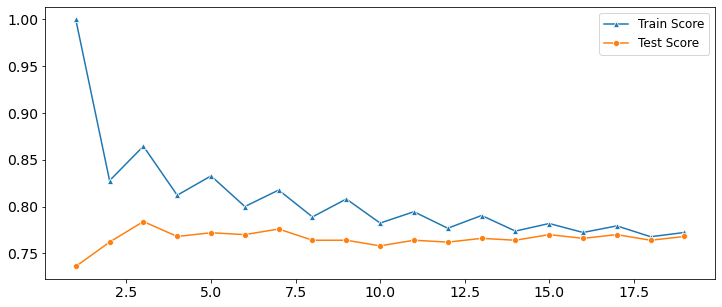

In [54]:
plt.figure(figsize=(12,5))
p = sns.lineplot(x=range(1,K_max),y=train_scores,marker='^',label='Train Score')
p = sns.lineplot(x=range(1,K_max),y=test_scores,marker='o',label='Test Score')

## Interpretable Models

In the field of medicine, interpretablity is very importance. Considering ethinity issues, the machine learning models cannot be used to replace doctors. In most cases, it works as a assisstant to doctor, so it is of crucial importance for doctors to understand how machine learning models made decisions.

KNN is not capable of that, so we decide to introduce two different models, a linear model 'logistic regression' and tree-based model 'random forest'. We will compare the performance of these models and check how they made decisions. However, this interpretation and visualization is somehow complicated. And the introduced libary might cause incompatable problems as well, so we put the code we used in the 'README.md' file and we just load the results here. 

### Logistic Regression

In [55]:
# check classification scores of logistic regression
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(max_iter=1e+6,C=1)
logreg.fit(X_train_std, y_train)
y_pred = logreg.predict(X_test_std)
y_pred_proba = logreg.predict_proba(X_test_std)[:, 1]

In [56]:
## Calculate the accuracy
LR_rightnumber=0
for m in range(len(y_pred)):  
    if y_pred[m] == y_test[m]:
        LR_rightnumber = LR_rightnumber + 1
    logistic_score = (LR_rightnumber / len(y_pred))
     
print(f"Accuracy is {logistic_score}")

Accuracy is 0.81



Feature importance foucs what features have the biggest impact on predictions. Here we used permutation importance for this model. 

The steps for calculating permutation importance: 
1. Get a trained model.
2. Shuffle the values in a single column, make predictions using the resulting dataset. Use these predictions and the true target values to calculate how much the loss function suffered from shuffling. That performance deterioration measures the importance of the variable you just shuffled.
3. Return the data to the original order (undoing the shuffle from step 2). Now repeat step 2 with the next column in the dataset, until you have calculated the importance of each column.

The permutation importance of Logistic Regression is shown below, the features with higher ranks are more important in the model we fitted. 

In [57]:
from IPython.display import HTML

HTML('./etc/lr_feature_importance.html')

Weight,Feature
0.0136 ± 0.0170,Pain Assessment Method_Patient Verbalized
0.0104 ± 0.0039,RUE Temp
0.0084 ± 0.0082,Urine Source_Indwelling Urinary Catheter
0.0076 ± 0.0085,LUE Temp
0.0076 ± 0.0125,Radial Pulse R
0.0072 ± 0.0138,Braden Friction/Shear
0.0072 ± 0.0078,Position_Right Side
0.0068 ± 0.0074,Position_Supine
0.0064 ± 0.0069,PostTib Pulses R
0.0052 ± 0.0086,Urine Color_Yellow


### Random Forest

In [58]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier

# Fit the model
rf = RandomForestClassifier(n_estimators=10)
rf.fit(X_train, y_train)

# Use score method to calculate the accuracy over the whole test set
acc=rf.score(X_test, y_test)
print(f"Accuracy is {acc}")


Accuracy is 0.824


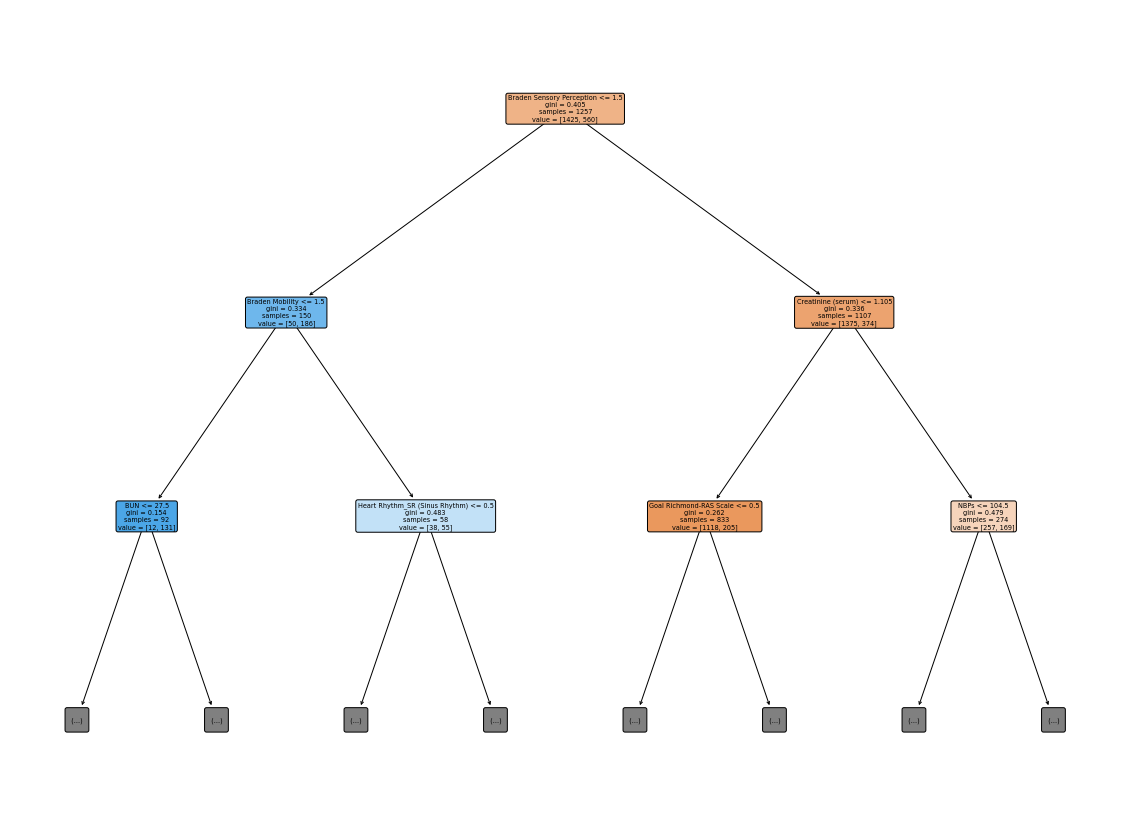

In [59]:
from sklearn.tree import plot_tree

fig = plt.figure(figsize=(20, 15))
tree_fig = plot_tree(rf.estimators_[0], max_depth=2,
          feature_names=X_train.columns, 
          filled=True, impurity=True, 
          rounded=True)

## Model Comparasion

In [60]:
model_score = {'KNN': [max_test_score], 'MYKNN':[max(myknn_test_scores)*0.01],'Logistic regression':[logistic_score],'Random Forest':[acc]}
all_model_score=pd.DataFrame(data=model_score.values(),index=model_score.keys(),columns=['score'])

<AxesSubplot:ylabel='score'>

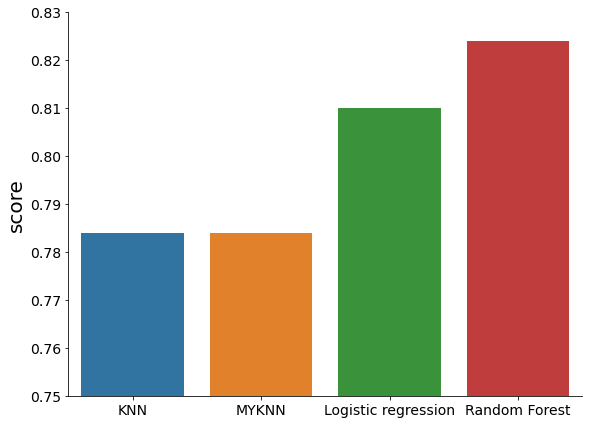

In [61]:
plt.figure(figsize=(8,6));fig_set()
plt.ylim(0.75,0.83)
sns.barplot(x=all_model_score.index,y='score',data=all_model_score)

# Conclusion

## Comparing Different Models
This model comparison showed that 'Logistic regression' had the highest prediction accuracy (0.81), followed by 'Random Frorest' (0.798). Both the KNN in sklearn and our own rewritten KNN have an accuracy of 0.78. All three are able to predict mortality to some extent. 

The results indicate that Logistic regression and Random Frorest are more suitable for small sample datasets with binary classification. Random Frorest and Logistic regression can derive the contribution of FEATURES, which can help users to pay attention to features that need to be able to reduce the mortality rate. 

However KNN does not have such interpretability,  KNN is that the principle is simple and the encapsulated KNN runs fast compared to the other two algorithms. However, when the dataset has very many feature parameters, the Euclidean distance of high-dimensional data will no longer follow the two-dimensional rule, which is the 'dimensional disaster'. So KNN is not suitable for datasets with too many features. During the experiment we also encountered the outlier problem, this problem causes the logistic regression model not to converge, the same problem has less effect on 'Random Frorest' and 'KNN'.

In summary, for the dataset and prediction problem used in this experiment, 'Random Frorest' is the most suitable machine learning algorithm. it has the advantages of both, speed, accuracy, and insensitivity to outliers.


Compared with the KNN model in sklearn, the KNN we wrote independently in this experiment has the same performance in terms of prediction accuracy. However, the running speed of it is lower than the KNN model in sklearn. The possible reason is that our model has high time complexity and the retention of the magnitude of the values is not further processed, resulting in high computational effort.